# Causal Inference:

In this post , we are going to talk about fundamentals of Causal Inference and how it is crucial in real life problems.

Causal inference is nothing but 

Cuasal inference is totally different than prediction. As data scientists, we are always used to meke predictions and overcomming benchmarks. Althought, the inference approach is about a deep understanding of the problem in a scientific way. 
This topic make us look at a problem in a Scientific view instead of a data view. As we are going to discuss, traditional predictive models rely on the fact that the future data are similar from what the model is accustomed to. But, when it changes, the model may terrible fail, even when in the traing (and also test) achieve greats results. 
t.

Ultimately, causal inference is about figuring out how the world really works, stripped of all delusions and misinterpretations. And now that we understand this, we can move forward to mastering some of the most powerful methods to remove bias, the weapons of the Brave and True to identify the causal effect.

To begun, we are goin top use the Directed acyclical Graph (DAG) as a useful tool to underestand causal association between two variables. Here is an generic example: 


In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

import graphviz as gr

from scipy import stats
from scipy.optimize import curve_fit

import daft
from causalgraphicalmodels import CausalGraphicalModel

warnings.simplefilter(action="ignore", category=FutureWarning)


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We first began wit a generical examples. In statistics is also a good idea the generate a sitetic data that we already know all the awnsers about that data. This simple example is good to show same key concepts in Causal Inference. 

The next example are a fungus treatment in plants growth. We are going to define some plants heights that is the initial measurement, some plants suffer with fungus and it make a deacresement in the plants growth. Other plants recieves a treatment for the fungus, so the probability of the fungus interview in the plant decrease. 

It is specially important in this context due to the fundamental problem of causal inference, we can never know the individual treatment effect because we only observe one of the potential outcomes. The treatment means a variable the has a causal effect on another. 

So, here is the example:

Let's define the variables:

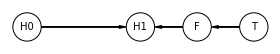

In [2]:

plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()


In [2]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
h0,9.96,2.04,6.34,13.75
h1,14.06,2.81,9.14,18.77
treatment,0.50,0.50,0.00,1.00
fungus,0.30,0.46,0.00,1.00


The "h0" variable means the initial height, h1 is the final measurement. The treatment is the proportion of plants that recived the fungus medicine; and the fungus is the proportion of plants that has the fungus in the segond growth measurement. 

Now, the big question is: The treatment really helped in the plant's growth? How to prove it? 

Maybe it seen like a simple quastion, but it is not. In a real scenario, we just have the data, and we don't know how is the truth unter the numbers. What we want is know if there isn't treatment, what would be the the heights of thats plants. Notice that is a question with no awnser, we can't observate this parallel world. 

It is a hot question because there is many factor that interfiers in the height of the plants, like water, shainy, and the genetics of being susceptible to fungus. So, based on that we have two possible hypotesis. The first is that the treatment really works, and if we do not apply it, the final heights would be smaller. The second is that the treatment do not works and the plants height are the same as if we do not apply the treatment. 

Can you figure out how solve this? 


The proportion of growth p is now a function of the predictor variables.

In [7]:
# p is the proportion of growth
# lets define the priori 
sim_p = np.random.lognormal(0, 0.25, int(1e4))
az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,1.03,0.26,0.59,1.51


Lets fit the simpliest model where the final height (h1) is based only by the initial height. 
This is the scenatio that we assume that the fungus do not interview in the plants growth. 

In [8]:
with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)
    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The acceptance probability does not match the target. It is 0.8821156604519111, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.42,0.02,1.38,1.46,0.0,0.0,3473.71,2700.54,1.0
sigma,1.99,0.15,1.73,2.26,0.0,0.0,3241.14,2705.75,1.0


Notice the plants would grow 42 %, in mean, of the initial value

In [10]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)
    p = a + bt * d.treatment + bf * d.fungus
    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)
    m_6_7_trace = pm.sample()
az.summary(m_6_7_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 283 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.48,0.03,1.43,1.53,0.0,0.0,2119.33,2353.23,1.0
bt,0.02,0.03,-0.04,0.08,0.0,0.0,2271.51,2558.07,1.0
bf,-0.29,0.04,-0.36,-0.22,0.0,0.0,2202.37,2595.55,1.0
sigma,1.43,0.11,1.24,1.63,0.0,0.0,2652.83,2363.71,1.0


This outcomes seens weird. The parameter of the treatment are close to zero. But, we already know that the treatment have a significant impact on the plants growth. 

The first problem here is how to interpret the Linear regression parameters. Each parameter means the importance of knowing a variable if we already know the others. In this context, the information of the treatment of each plant is not relevant if we alread know about the presence of fungus. 

The presence of fungus is common called post-treatment variable bause it is consequences of other variables. So when we control for fungus, the model is implicitly answering the question: Once we already know whether or not a plant developed fungus, does soil treatment matter? The answer is “no,” because soil treatment has its effects on growth through reducing fungus. But we actually want to know, based on the design of the experiment, is the impact of treatment on growth. To measure this properly, we should omit the post-treatment variable fungus.

It is important to notice that the model will work fine for prediction. But, now, it isn't our propose. 


In [11]:
with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample()

az.summary(m_6_8_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 165 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.33,0.03,1.28,1.38,0.0,0.0,2043.42,2343.20,1.0
bt,0.15,0.04,0.08,0.22,0.0,0.0,2160.97,2228.24,1.0
sigma,1.89,0.14,1.65,2.15,0.0,0.0,2046.98,1825.27,1.0


Now, we can see that the treatment really matter. 


One interest thing about this variable ie the conditional independence. notation H1 ⊥⊥ T|F -> h1 é independente de T, ao se condicionar em F. There is no information in T about H1 that is not also in F.  So once we know F, learning T provides no additional information about H1.

So, what is the big deal here? The first thing is that just adding variables to a model can do a lot of damage. In a first look, could be intuitive that the treatment does not has effect, so it meight be excluded in the prediction. As we saw, it could had been a huge mistake.  

Now, let's go to a real world problem. 

### US Berclay discrimination


In [2]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
d_ad = pd.read_csv("Data/UCBadmit.csv", sep=";")
d_ad.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


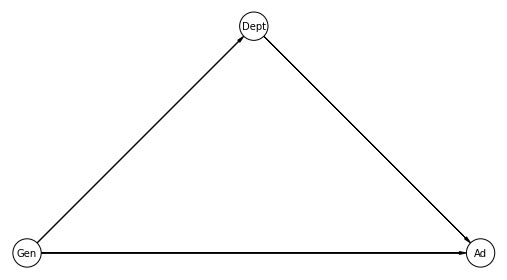

In [16]:
plant_dag = CausalGraphicalModel(
    nodes=["Gen", "Dept","Ad"], edges=[("Gen", "Dept"), ("Gen", "Ad"), ("Dept", "Ad")]
)
pgm = daft.PGM()
coordinates = {"Gen": (0, 0), "Dept": (4, 4), "Ad": (8, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
# plt.gca().invert_yaxis()

The Gen (Gender) to Ad (admission) path is the discriminative path. 

In [3]:
data = d_ad.groupby(['applicant.gender']).mean()
data['Adimission rate'] = data['admit']/data['applications']
data[['Adimission rate']]

,Adimission rate
applicant.gender,
female,0.303542
male,0.445188


So, this is the main motive of the suspecious discrimination. The mean adimission rate of the  male is higher than the female. 

Let's define a simple Generalized Linear Models. 


$$ Adim \sim  Binomial(N, p)$$
$$ logit(p) = a_{[m,f]} $$
$$ a_m \sim Normal(0,1)$$
$$ a_f \sim Normal(0,1)$$


In [40]:
# binomial model of overall admission probability
data = d_ad[d_ad['applicant.gender']=='female']
with pm.Model() as m_binom:
    a_f = pm.Normal("af", 0, 1)
    p = pm.math.invlogit(a_f)
    admit = pm.Binomial("admit", p=p, n=data.applications, observed=data.admit)
    trace_binom_f = pm.sample(1000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [af]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8790397675934343, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7051556742480998, but should be close to 0.8. Try to increase the number of tuning steps.


In [42]:
data = d_ad[d_ad['applicant.gender']=='male']
#data = d_ad
with pm.Model() as m_binom:
    a_m = pm.Normal("am", 0, 1)
    p = pm.math.invlogit(a_m)
    admit = pm.Binomial("admit", p=p, n=data.applications, observed=data.admit)
    trace_binom_m = pm.sample(1000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [am]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 27 seconds.


<AxesSubplot:ylabel='Density'>

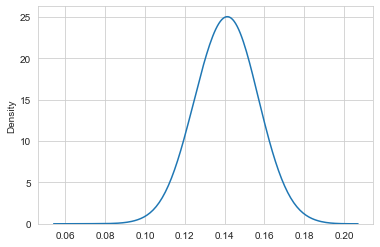

In [44]:
diff_post =np.array(list(map(inv_logit,trace_binom_m['am']))) - np.array(list(map(inv_logit,trace_binom_f['af'])))
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(diff_post), bw=0.5)


That’s because you’ve just committed the gravest sin of mistaking association for causation. To understand why, let’s take a look into the main enemy of causal inference.

We just subtract the mean outcomes between the two groups, and it cause a mislanding undertanging. 

When confronted with the claim that wonmen have less chance to been adimitted in University beacuse of discrimination, we can rebut it by saying that these wonmen will probably not been adimitted in University, even without discrimination.

But now, we are going the prove if there is discrimination or not. 

To begun, we will create a parameter for each deptartment and gender. And then, fit the model. 

In [4]:
df_data = d_ad.groupby(['applicant.gender','dept']).sum()
coords = {"gender": df_data.index, "data":df_data.columns}
with pm.Model(coords=coords) as m_binom:
    par = pm.Normal("par", 0, 1,shape =(2,6))
    #data = pm.Data("data",df_data, dims=("gender", "data"))
    p = pm.math.invlogit(par)
    admit_obs  = pm.Data("admit_obs", df_data.admit.values.reshape(2,6))
    pm.Binomial("admit", p=p, n=df_data.applications.values.reshape(2,6), observed=admit_obs)
    trace_binom = pm.sample(1000, tune=2000,return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [par]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 52 seconds.


In [5]:
az.summary(trace_binom).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"par[0, 0]",1.47,0.24,1.01,1.92,0.0,0.0,6178.0,3110.0,1.0
"par[0, 1]",0.65,0.39,-0.12,1.34,0.0,0.0,5294.0,2845.0,1.0
"par[0, 2]",-0.66,0.08,-0.82,-0.50,0.0,0.0,5229.0,2965.0,1.0
"par[0, 3]",-0.62,0.11,-0.82,-0.42,0.0,0.0,6008.0,2992.0,1.0
"par[0, 4]",-1.14,0.12,-1.36,-0.92,0.0,0.0,6169.0,3253.0,1.0
"par[0, 5]",-2.49,0.20,-2.88,-2.13,0.0,0.0,5668.0,3187.0,1.0
"par[1, 0]",0.49,0.07,0.36,0.62,0.0,0.0,5440.0,3040.0,1.0
"par[1, 1]",0.53,0.09,0.38,0.70,0.0,0.0,4388.0,2935.0,1.0
"par[1, 2]",-0.53,0.11,-0.73,-0.31,0.0,0.0,5944.0,3602.0,1.0
"par[1, 3]",-0.70,0.10,-0.89,-0.50,0.0,0.0,6390.0,3051.0,1.0


In [6]:
from scipy.stats import binom
params = trace_binom.posterior.par.data.reshape(4000,2,6)
myInvLogit = lambda t: inv_logit(t)
vfunc = np.vectorize(myInvLogit)
params = vfunc(params)

Here is the posterior distribution of the posterior parametes, back in regular scale. It can be interpretade as the tendency of a person to be adimitted acording to gander and deptartment. 

Now, let's simulate from pesterior to see if will be a divergence between male and female admission. 

In [17]:
params_df = pd.DataFrame([])
for i,dept in enumerate(['A','B','C','D','E','F']):   
    for j,gen in enumerate(['male','female']):
        params_df[gen + '_'+ dept] = params[:,j,i]
params_df.describe(include = 'all').drop(index = 'count')

,male_A,female_A,male_B,female_B,male_C,female_C,male_D,female_D,male_E,female_E,male_F,female_F
mean,0.810591,0.619933,0.652748,0.629542,0.341347,0.370978,0.350845,0.332367,0.242121,0.282715,0.077572,0.066288
std,0.036778,0.016747,0.085598,0.020315,0.019064,0.026137,0.024537,0.023238,0.021538,0.032616,0.014078,0.012273
min,0.666046,0.560141,0.311917,0.549649,0.278721,0.279093,0.270102,0.250920,0.166217,0.174563,0.037459,0.024886
25%,0.787038,0.608278,0.596912,0.616124,0.328476,0.352997,0.333886,0.316094,0.227249,0.260947,0.067359,0.057558
50%,0.813308,0.619944,0.656644,0.629625,0.341215,0.371050,0.350922,0.331480,0.241919,0.282157,0.077049,0.065463
75%,0.836278,0.631590,0.713937,0.643417,0.354308,0.388643,0.367482,0.348078,0.255967,0.303731,0.086818,0.074283
max,0.916286,0.695559,0.903217,0.701165,0.421822,0.462800,0.438866,0.423594,0.324159,0.406868,0.136397,0.118166


In [12]:
params.shape

(4000, 2, 6)

#### Sampling from posterior: 

In [109]:
n_gender = 2 
n_dept = 6
post = pd.DataFrame([])

for i,dept in enumerate(['A','B','C','D','E','F']):    
#     for j,gender in enumerate(['male','female']):
    N = dat.iloc[i*2,-1].astype(np.int32) + dat.iloc[i*2 + 1,-1].astype(np.int32)
    post[dept] = (binom.rvs(N, params[:,j,0]) - binom.rvs(N, params[:,j,1]))/N


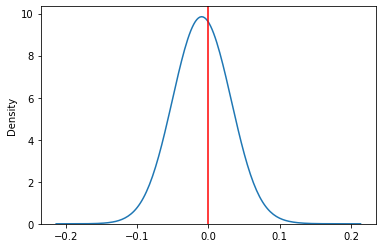

In [123]:

#post = post.div(dat['applications'].astype(np.int32).to_list(), axis='columns')
sns.kdeplot(post.values.flatten(), bw=0.5)
plt.axvline(0, 0,10,color = 'red')

So, as we can see, there is not a gender tendency. 

In [ ]:


# # Poisson model of overall admission and rejection rates
# with pm.Model() as m_pois:
#     a = pm.Normal("a", 0, 1.5, shape=2)
#     lam = pm.math.exp(a)

#     admit = pm.Poisson("admit", lam[0], observed=d_ad.admit)
#     rej = pm.Poisson("rej", lam[1], observed=d_ad.reject)

#     trace_pois = pm.sample(1000, tune=2000)
# m_pois = az.summary(trace_pois).round(2)
# (np.exp(m_pois["mean"][0]) / (np.exp(m_pois["mean"][0]) + np.exp(m_pois["mean"][1]))).round(3)

UC BERkley explanation:



 
 The bias is given by how the treated and control group differ before the treatment, that is, in case neither of them has received the treatment. 
 
 We will talk more about that once we enter confounding, but for now you can think of bias arising because many things we can’t control are changing together with the treatment. 
 
 Understanding this is not just remembering the equation. There is a strong intuitive argument here. To say that E[y0|t =0] = E[yo| t =1] is to say that treatment and control group are comparable before the treatment. Or, in the case that the treated had not been treated, if we could observe its y0, then its outcome would be the same as the untreated. Mathematically, the bias term would vanish:
 
 Not only that, but E[y0 - y1|t =0] = E[yo - y1| t =1] , simply because the treated and untreated are exchangeable. Hence, in this case, the difference in means BECOMES the causal effect:


In [ ]:
Criar um experimento que se usa todas as
variáveis do modelo sem nenum tipo de seleção e tenta-se prever com regressão linear
e depois faz a mesma previsão com as variáveis elecionadas (vai mudar?)

Explicar que os modelos não causais tendem a ser melhores para predição. 

In [ ]:
US Berkley discrimination example. 

In [ ]:
# cleanup_nums = {"applicant.gender": {"male": 1, "female": 2},
#                 "dept": {"A": 1, "B": 2, "C": 3, "D": 4,
#                                   "E": 5, "F": 6}}
# dat = d_ad.replace(cleanup_nums)
# coords = {"variables": dat.columns.values}
# with pm.Model(coords=coords) as m_binom:
#     par = pm.Normal("par", 0, 1,shape =(2,6))
    
#     data = pm.Data("data",dat, dims=["applicant.gender", "dept"])
    
#     obs = pm.Data("obs",dat, dims=("admit"))
#     N = pm.Data("N",dat, dims=("applications"))
#     p = pm.math.invlogit(par)

#     pm.Binomial("admit", p=p, n=N, observed=obs)
#     trace_binom = pm.sample(1000, tune=2000,return_inferencedata=True)

### References:
Seguit a methodologia do curso: https://www.codecademy.com/learn/learn-the-basics-of-causal-inference-with-r/modules/conceptual-foundations-of-causal-inference


 First, this equation tells why association is not causation. https://matheusfacure.github.io/python-causality-handbook/01-Introduction-To-Causality.html
